In [5]:
import pandas as pd
import math
import networkx as nx
import networkx.algorithms
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import sklearn.cluster
import sklearn.preprocessing

#### Fix 1: Clean Up Import Statements

Instead of using raw module names like `pandas.Series` throughout the notebook, I standardized all imports at the top: `import pandas as pd`, `import networkx as nx`, etc. This made the code cleaner, easier to type, and more consistent.

In [7]:
df = pd.read_csv('company_directorships.csv')
df.software_background = df.software_background.map(lambda x: x == 't')
df.sample(5)

,company_name,cikcode,director_name,software_background,start_date,end_date
10088,"REVVITY, INC.",31791,ALEXIS P. MICHAS,False,2011-03-16,2025-03-12
11540,TELOS CORP,320121,"MAJOR GENERAL JOHN W. MALUDA (USAF, RET.)",True,2009-10-27,2015-04-22
10212,ROYAL GOLD INC,85535,JAMIE C. SOKALSKY,False,2015-10-01,2019-10-07
11302,"SUPERIOR GROUP OF COMPANIES, INC.",95574,KENNETH HOOTEN,False,2011-03-10,2012-03-13
2758,COMTECH TELECOMMUNICATIONS CORP /DE/,23197,FRED KORNBERG,False,2015-11-23,2019-11-15


In [8]:
compensation_and_demographics_raw = pd.read_csv('director-details.csv')
compensation_and_demographics_raw['NAME'] = compensation_and_demographics_raw.name.str.upper()

def most_common(series):
    mode_vals = series.mode()
    return mode_vals[0] if not mode_vals.empty else None

compensation_and_demographics = pd.DataFrame({
    'age': compensation_and_demographics_raw.groupby('NAME')['age'].max(),
    'compensation': compensation_and_demographics_raw.groupby('NAME')['compensation'].sum(),
    'gender': compensation_and_demographics_raw.groupby('NAME')['gender'].agg(most_common)
})

compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics['compensation']).map(math.log10)
compensation_and_demographics

,age,compensation,gender,log_compensation
NAME,,,,
A. CATHERINE NGO,64,1006154,female,6.002665
A. EUGENE WASHINGTON,70,324871,male,5.511712
A. F. PETROCELLI,80,47000,male,4.672107
A. FARAZ ABBASI,52,113631,male,5.055501
A. LARRY CHAPMAN,78,259500,male,5.414139
...,...,...,...,...
ZACKARY IRANI,58,360103,male,5.556428
ZAHID AFZAL,62,0,male,0.000000
ZENA SRIVATSA ARNOLD,46,189960,female,5.278664


#### Fix 2: Refactor Compensation Aggregation

The original code for aggregating compensation and demographics was long and less readable. I refactored it using clear `groupby` calls and a helper function to compute the most common gender. This made the logic easier to follow and avoided repeated code, especially when handling missing or inconsistent values.

In [10]:
# Check for missing values
print("Missing values in director-details.csv:")
print(compensation_and_demographics_raw.isnull().sum())

print("\nMissing values in company_directorships.csv:")
print(df.isnull().sum())

Missing values in director-details.csv:
id                 0
url                0
name               0
age                0
role               1
compensation       0
source_excerpt     0
created_at         0
gender            21
NAME               0
dtype: int64

Missing values in company_directorships.csv:
company_name           0
cikcode                0
director_name          0
software_background    0
start_date             0
end_date               0
dtype: int64


#### Fix 3: Check for Missing Values

**Problem**: The original code assumes the datasets are clean, but doesn't validate this.

**Fix**: I added `.isnull().sum()` checks for both datasets.

**Why it matters**: This revealed 21 missing values in the `gender` column of the `director-details.csv`. Identifying and handling missing data is essential for reliable analysis, especially when doing aggregations or merges.

In [12]:
compensation_and_demographics.gender.value_counts(dropna=False)

gender
male       3850
female     1550
None         19
unknown       2
Name: count, dtype: int64

In [13]:
directorship_counts = df.groupby('director_name').company_name.nunique().sort_values()
directorship_counts

director_name
A CHARLENE SULLIVAN, PH.D.     1
MICHAEL L. KUTA                1
MICHAEL L. LARUSSO             1
MICHAEL L. MILLER              1
MICHAEL L. OWENS               1
                              ..
MARTIN L. FLANAGAN            13
ANN BARNETT STERN             13
TERESA M. RESSEL              13
BRUCE L. CROCKETT             13
ALBERT R. DOWDEN              14
Name: company_name, Length: 11827, dtype: int64

<Axes: xlabel='company_name'>

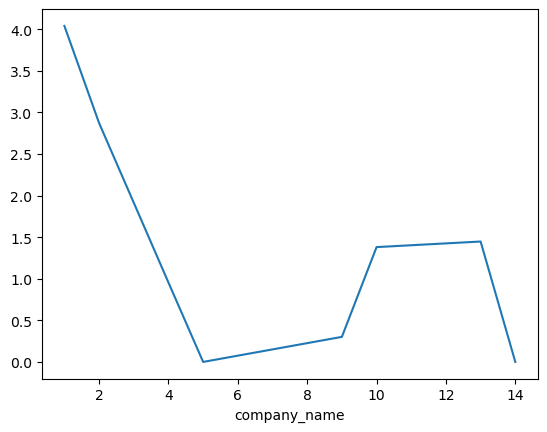

In [14]:
directorship_counts.value_counts().sort_index().map(math.log10).plot()

In [15]:
graph = nx.Graph()

In [16]:
people = []
companies = []
for company_name, director_name in zip(df.company_name, df.director_name):
    graph.add_edge(company_name, director_name)
    people.append(director_name)
    companies.append(company_name)

In [17]:
biggest_connected_graph = graph.subgraph(list(nx.connected_components(graph))[0])
print(biggest_connected_graph)

Graph with 8204 nodes and 9233 edges


In [18]:
%%time
centrality = pd.DataFrame({
    'eigen': pd.Series(nx.eigenvector_centrality(biggest_connected_graph)),
    'degree': pd.Series(nx.algorithms.degree_centrality(biggest_connected_graph)),
    'betweenness': pd.Series(nx.betweenness_centrality(biggest_connected_graph, k=500, seed=42))  # sampled betweenness
})
centrality['is_person'] = centrality.index.map(lambda x: x in people)


CPU times: user 47 s, sys: 567 ms, total: 47.6 s
Wall time: 58.4 s


In [19]:
scaler = MinMaxScaler()
centrality[['eigen_norm', 'degree_norm', 'betweenness_norm']] = scaler.fit_transform(
    centrality[['eigen', 'degree', 'betweenness']]
)

#### Fix 4: Normalize Centrality Scores

I added Min-Max normalization to the centrality scores. Since eigenvector, degree, and betweenness values are on very different scales, normalizing them to a 0–1 range helps make comparisons more meaningful. This is especially useful when visualizing or ranking directors by influence.

### Centrality Extension – Betweenness Centrality

To identify the most influential directors in the network, we use three centrality measures:

- **Degree Centrality**: Directors with high degree scores indicates directors with many direct board connections. They’re useful for quickly spreading information or activating a large number of contacts.

- **Eigenvector Centrality**: Directors who are connected to other well-connected individuals. These are the insiders — influential not because of quantity, but quality of connections.

- **Betweenness Centrality**: Directors who act as bridges between disconnected groups. These people are crucial connectors. Even if they don’t have the most contacts, they can introduce the company to **new corporate circles**, making them ideal for brokering deals with potential U.S. acquirers.


In [22]:
people_df = centrality[centrality.is_person].merge(compensation_and_demographics, left_index=True, right_index=True)

In [23]:
# Show Top Directors by Each Centrality
print("Top 10 by Eigenvector Centrality")
display(people_df.sort_values('eigen', ascending=False).head(10))

print("Top 10 by Degree Centrality")
display(people_df.sort_values('degree', ascending=False).head(10))

print("Top 10 by Betweenness Centrality")
display(people_df.sort_values('betweenness', ascending=False).head(10))

Top 10 by Eigenvector Centrality


,eigen,degree,betweenness,is_person,eigen_norm,degree_norm,betweenness_norm,age,compensation,gender,log_compensation
ELIZABETH KRENTZMAN,0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,65,3408245,female,6.532531
CAROL DECKBAR,0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,62,43263,female,4.636127
ELI JONES,0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,63,3063255,male,6.486183
DOUGLAS SHARP,0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,50,0,male,0.000000
"JAMES ""JIM"" LIDDY",0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,65,27531,male,4.439838
JOEL W. MOTLEY,0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,72,3118870,male,6.493997
ROBERT C. TROCCOLI,0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,75,3225755,male,6.508632
PREMA MATHAI-DAVIS,0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,74,3208265,female,6.506270
"ANTHONY J. LACAVA, JR.",0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,68,3461400,male,6.539252
BETH ANN BROWN,0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,56,6363810,female,6.803717


Top 10 by Degree Centrality


,eigen,degree,betweenness,is_person,eigen_norm,degree_norm,betweenness_norm,age,compensation,gender,log_compensation
TERESA M. RESSEL,0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,62,3190130,female,6.503809
ROBERT C. TROCCOLI,0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,75,3225755,male,6.508632
ELI JONES,0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,63,3063255,male,6.486183
ELIZABETH KRENTZMAN,0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,65,3408245,female,6.532531
DANIEL S. VANDIVORT,0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,69,3353265,male,6.525468
"JAMES ""JIM"" LIDDY",0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,65,27531,male,4.439838
JOEL W. MOTLEY,0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,72,3118870,male,6.493997
PREMA MATHAI-DAVIS,0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,74,3208265,female,6.506270
DOUGLAS SHARP,0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,50,0,male,0.000000
CYNTHIA HOSTETLER,0.102439,0.001585,3.447855e-07,True,0.478742,0.222222,0.000004,62,3371400,female,6.527810


Top 10 by Betweenness Centrality


,eigen,degree,betweenness,is_person,eigen_norm,degree_norm,betweenness_norm,age,compensation,gender,log_compensation
KERRII B. ANDERSON,1.185926e-17,0.000366,0.036610,True,5.542346e-17,0.037037,0.445583,66,554508,female,5.743909
PAUL D. DONAHUE,1.696429e-15,0.000366,0.030693,True,7.928149e-15,0.037037,0.373559,68,8250000,male,6.916454
"CHARLES K. STEVENS, III",9.750916e-13,0.000244,0.029939,True,4.557026e-12,0.018519,0.364390,65,495885,male,5.695382
MATTHEW J. ESPE,6.003444e-18,0.000366,0.028256,True,2.805670e-17,0.037037,0.343903,66,125000,male,5.096913
MICHAEL H. KEOWN,5.830894e-18,0.000244,0.027291,True,2.725030e-17,0.018519,0.332153,62,212506,male,5.327373
MARK A. BLINN,3.417870e-15,0.000610,0.026892,True,1.597319e-14,0.074074,0.327305,63,594975,male,5.774499
JAMES H. MORGAN,5.266725e-20,0.000244,0.026771,True,2.461369e-19,0.018519,0.325833,77,221200,male,5.344787
MICHAEL J. HAPPE,3.210636e-07,0.000244,0.024698,True,1.500469e-06,0.018519,0.300596,53,250000,male,5.397942
J. STEVEN WHISLER,1.729295e-15,0.000366,0.023432,True,8.081746e-15,0.037037,0.285195,70,718831,male,5.856627
DONNA W. HYLAND,1.690444e-15,0.000244,0.023047,True,7.900178e-15,0.018519,0.280501,64,545270,female,5.736612


### Interpretation of Top Directors by Centrality Measures

When examining the top directors by **eigenvector** and **degree centrality**, we find that the lists are identical. Directors such as **Elizabeth Krentzman**, **Eli Jones**, and **Joel W. Motley** appear at the top of both rankings, with identical values across both metrics.

This suggests that the most well-connected directors (by number of board links) are also deeply embedded in influential parts of the network — indicating a **densely interconnected corporate core** where influence and popularity overlap. These individuals are ideal for **broad outreach and strategic influence within a known network**.

However, the **betweenness centrality** rankings reveal a completely different set of directors, including **Michael J. Happe**, **Mark A. Blinn**, and **Kerrii B. Anderson**, who do **not appear** in the eigenvector or degree lists. Despite having lower connectivity, these individuals act as **bridges between disconnected clusters**, making them **key brokers** for cross-network collaboration.

In [25]:
df[df.director_name == 'ELIZABETH KRENTZMAN']

,company_name,cikcode,director_name,software_background,start_date,end_date
6297,Invesco Advantage Municipal Income Trust II,908993,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6352,Invesco Bond Fund,5094,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6407,Invesco California Value Municipal Income Trust,895531,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6462,Invesco High Income Trust II,846671,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6512,Invesco Municipal Income Opportunities Trust,835333,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6546,Invesco Municipal Opportunity Trust,884152,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6601,Invesco Municipal Trust,877463,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6656,Invesco Pennsylvania Value Municipal Income Trust,895528,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6706,Invesco Quality Municipal Income Trust,885125,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6740,Invesco Senior Income Trust,1059386,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02


In [26]:
robust_scaler = sklearn.preprocessing.RobustScaler()
age_and_demographics_scaled = robust_scaler.fit_transform(people_df[['age', 'log_compensation', 'degree', 'eigen']])


In [27]:
dbscan = sklearn.cluster.DBSCAN(eps=0.4)
people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
people_df.cluster_id.value_counts()

cluster_id
 1    3117
 0     385
 2     109
-1      72
 3      24
 4      19
 7       8
 6       5
 5       3
Name: count, dtype: int64

<Axes: xlabel='age', ylabel='log_compensation'>

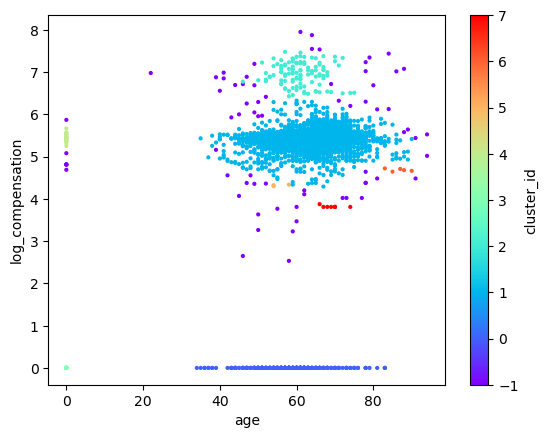

In [28]:
people_df.plot.scatter(x='age', y='log_compensation', c='cluster_id', cmap="rainbow", s=4)

In [29]:
people_df.loc['ELIZABETH KRENTZMAN']

eigen               0.102439
degree              0.001585
betweenness              0.0
is_person               True
eigen_norm          0.478742
degree_norm         0.222222
betweenness_norm    0.000004
age                       65
compensation         3408245
gender                female
log_compensation    6.532531
cluster_id                 2
Name: ELIZABETH KRENTZMAN, dtype: object

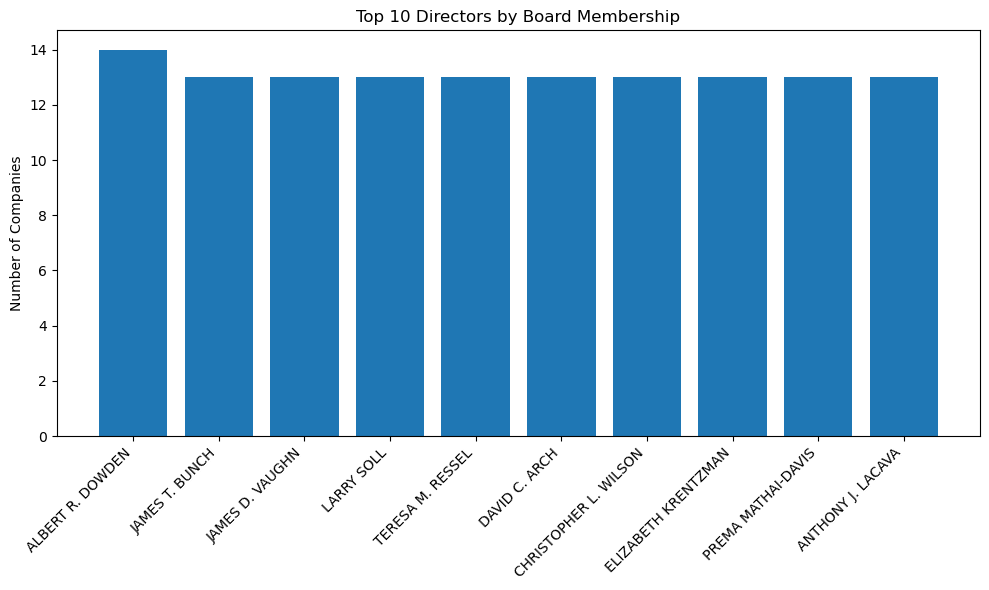

In [30]:
# Count how many unique companies each person is affiliated with
director_company_counts = df.groupby('director_name')['company_name'].nunique().sort_values(ascending=False)

# Display top 10 directors with most company affiliations
top_directors_by_company = director_company_counts.head(10)

# Prepare DataFrame
top_directors_df = pd.DataFrame(top_directors_by_company).reset_index()
top_directors_df.columns = ['NAME', 'company_count']
top_directors_df['NAME'] = top_directors_df['NAME'].str.upper()

# Merge with centrality data
merged = centrality.reset_index().rename(columns={'index': 'NAME'})
merged['NAME'] = merged['NAME'].str.upper()
company_merge = pd.merge(top_directors_df, merged, on='NAME', how='left')


plt.figure(figsize=(10, 6))
plt.bar(company_merge['NAME'], company_merge['company_count'], label='Company Count')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Companies')
plt.title('Top 10 Directors by Board Membership')
plt.tight_layout()
plt.show()

### Task 3 – Exploring Unused Feature: `company_name`

To extend analysis, I examined the `company_name` column from the `company_directorships.csv` dataset — a feature not directly used in the network centrality analysis. I counted how many unique companies each director is affiliated with to understand their board-level reach.

This gives us insight into which individuals are the most widely connected across different organizations. Directors serving on many boards may have broader influence and stronger industry networks, making them ideal connectors for potential acquisitions or strategic partnerships — a key concern for our venture capital fund.

The bar chart shows the top 10 directors by number of company affiliations. Albert R. Dowden and James T. Bunch, for instance, serve on 13–14 boards, highlighting their potential to bridge across corporate structures regardless of their centrality score.